In [1]:
import numpy as np
%cd /home/jeroen/repos/traffic-scheduling/network/
from generate_network import generate_simple_instance
from util import draw_network, plot_schedule

/home/jeroen/repos/traffic-scheduling/network


## Instance generation

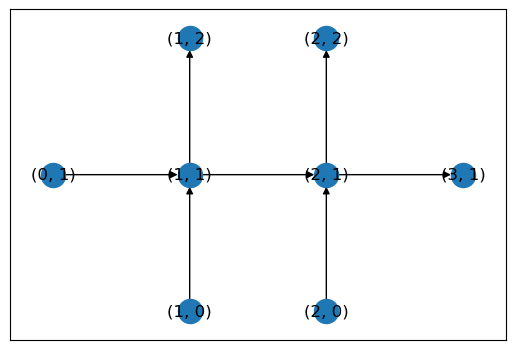

In [2]:
instance = generate_simple_instance()
draw_network(instance['G'])

## Verfication

We implement an independent checker that verifies that every constraint holds on the calculated crossing time lower bounds. Note that it can thus also be used to verify a complete schedule.

In [3]:
from itertools import combinations
from util import vehicle_indices, dist

def verify_LB(instance, LB, order):
    G = instance['G']
    route = instance['route']
    vmax = instance['vmax']

    indices = vehicle_indices(instance)
    
    # release dates
    for r, k in indices:
        v0 = route[r][0]
        assert instance['release'][r][k] <= LB[r, k, v0]

    # conjunctive constraints
    for r, k in indices:
        for v in route[r]:
            if k > 0:
                assert LB[r, k - 1, v] + instance['length'] / vmax <= LB[r, k, v]
    
    # travel constraints
    for r, k in indices:
        for l in range(1, len(route[r])):
            v = route[r][l - 1]
            w = route[r][l]
            assert LB[r, k, v] + dist(G, v, w) / vmax <= LB[r, k, w]

    # buffer constraints
    for r, k1 in indices: # i = (r,k1)
        for l in range(1, len(route[r])):
            v = route[r][l - 1]
            w = route[r][l]
            k2 = k1 + G[v][w]['capacity'] # j = (r,k2)
            if (r, k2) in indices: # (i,j,v,w) \in \mathcal{F}
                rho = G[v][w]['capacity'] * instance['length'] / vmax - G[v][w]['dist'] / vmax
                assert LB[r, k1, w] + rho <= LB[r, k2, v]

    # disjunctive constraints
    sigma = (instance['length'] + instance['width']) / instance['vmax']
    for node, node_order in order.items():
        for (r1, k1), (r2, k2) in combinations(node_order, 2):
            if r1 != r2:
                # disjunctive constraint
                assert LB[r1, k1, node] + sigma <= LB[r2, k2, node]

## Automaton

We assume that routes are edge-disjoint, which allows us to treat every route in isolation.

In [4]:
from automaton import Automaton
from networkx import get_node_attributes

In [9]:
automaton = Automaton(instance)

In [10]:
LB0 = get_node_attributes(automaton.D, 'LB')
verify_LB(instance, LB0, automaton.order)

In [11]:
automaton.step(0, (1, 1))
automaton.step(0, (1, 1))
automaton.step(2, (1, 1))
automaton.step(2, (2, 1))

In [12]:
LB1 = get_node_attributes(automaton.D, 'LB')
verify_LB(instance, LB1, automaton.order)

In [13]:
automaton.order

{(1, 1): [(0, 0), (0, 1), (2, 0)], (2, 1): [(2, 0)]}

In [14]:
automaton.unscheduled

{(0, (1, 1)): [2],
 (1, (2, 1)): [0, 1, 2],
 (2, (1, 1)): [1, 2],
 (2, (2, 1)): [1, 2]}

In [15]:
automaton.last_order

{(0, (1, 1)): 1, (1, (2, 1)): None, (2, (1, 1)): 0, (2, (2, 1)): 0}

### Random policy

In [21]:
from random import choice
from itertools import chain

while not automaton.done:
    candidates = [(r, k, node) for (r, node), values in automaton.unscheduled.items() for k in values]
    r, k, node = choice(candidates)
    automaton.step(r, node)

In [22]:
automaton.order

{(1, 1): [(0, 0), (0, 1), (2, 0), (2, 1), (0, 2), (2, 2)],
 (2, 1): [(2, 0), (1, 0), (1, 1), (1, 2), (2, 1), (2, 2)]}

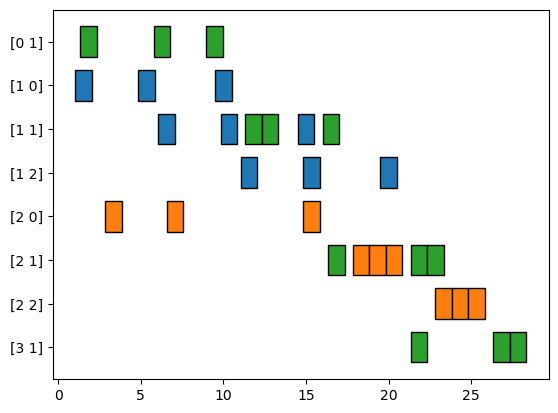

In [23]:
LB = get_node_attributes(automaton.D, 'LB')
plot_schedule(instance, LB)